In [1]:
from IPython.display import HTML
HTML('''<script>

code_show=true;

function code_toggle() {

if (code_show){

$('div.input').hide();

} else {

$('div.input').show();

}

code_show = !code_show

}

$( document ).ready(code_toggle);

</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve 
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
import metrics
import pickle
%pylab inline
pd.set_option('display.max_column',None)

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


## 2. Generate dataset
I will use the script [dataset_for_modeling.py](./dataset_for_modeling.py) that prepares the data as explained in the Exploratory Data Analysis ([Data_modeling_notebook chapter 2](./TBV1_classification_model.ipynb))

In [3]:
import dataset_for_modeling

Total sample reserved: 445
Total population before train and test split: 8448
X_train, y_train, X_test, y_test and data_reserved returned


In [4]:
X_train = dataset_for_modeling.X_train
y_train = dataset_for_modeling.y_train
X_test = dataset_for_modeling.X_test
y_test = dataset_for_modeling.y_test

## 3.  Xgboost tuning

In this Notebook I am going to fine tune the XGboost hyperparameters to try to improve the result.   
I am going to follow a similar approach, although not exhaustive, to the proposed in this article https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/:   

With Gridsearch:  
1) choose a learning rate (I will choose the default value of 0.1) and determine the optimal number of trees for this learning rate. This should range around 40-70. 

2) Tune tree-specific parameters for decided learning rate and number of trees. 

3) I test with different learning rates


Main assumptions:   

**- Managing imabalanced data**:  with class_weight 
  

**- Metrics**: I will fit recall_score and plot othe important classification metrics: AUC, Roc curve, Precision & Recall curve, f1_score, Cummulative Gain and Lift (only with best estimator)


**- Modeling Steps**:   
1) Generate Classifier
2) Fit   
3) Metrics  
4) Compare results   

#### 1) Classifier

**Estimator 1: clf_xgb_t1**  
I search the optimal number of trees for learning_rate = 0.1,

In [5]:
pipe_xgb =  Pipeline([('scaler',StandardScaler()),
                     ('classifier', xgb.XGBClassifier(learning_rate = 0.1,                                                
                                                      max_features='sqrt',
                                                      max_depth=3,                                                 
                                                      subsample=0.8,
                                                      class_weight='balanced',
                                                      booster = 'gbtree',
                                                      random_state=42))])


param_grid={'classifier__n_estimators':np.arange(40,70,10)}

# Instanciate the classifier    
clf_xgb_t1 = GridSearchCV(pipe_xgb, param_grid,cv = 5,
                          iid=True,verbose=2,
                          n_jobs = -1, 
                          scoring = 'recall')

# Fit
clf_xgb_t1.fit(X_train,y_train)

# Results
clf_xgb_t1.best_params_, clf_xgb_t1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.4s finished


({'classifier__n_estimators': 60}, 0.015151515151515152)

**Estimator 2: clf_xgb_t2**   
I tune tree-specific parameters for decided learning rate and number of trees. 

In [6]:
pipe_xgb =  Pipeline([('scaler',StandardScaler()),
                     ('classifier', xgb.XGBClassifier(learning_rate = 0.1,
                                                      n_estimators = 60,
                                                      subsample=0.8,
                                                      class_weight='balanced',
                                                      booster = 'gbtree',
                                                      random_state=42))])


param_grid={'classifier__max_depth': np.arange(3,15,2),
            'classifier__max_features': ['sqrt','log2']}

# Instanciate the classifier    
clf_xgb_t2 = GridSearchCV(pipe_xgb, param_grid,cv = 5,
                          iid=True,verbose=2,
                          n_jobs = -1, 
                          scoring = 'recall')


# Fit
clf_xgb_t2.fit(X_train,y_train)

# Results
clf_xgb_t2.best_params_, clf_xgb_t2.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


({'classifier__max_depth': 13, 'classifier__max_features': 'sqrt'},
 0.12424601161283048)

**Estimator 3: clf_xgb_t3**   
I tune subsample

In [7]:
pipe_xgb =  Pipeline([('scaler',StandardScaler()),
                     ('classifier', xgb.XGBClassifier(learning_rate = 0.1,
                                                      n_estimators = 60,
                                                      max_depth = 13,
                                                      max_features = 'sqrt',
                                                 #     min_samples_leaf = 20,
                                                 #     min_samples_split = 20,                                                      
                                                      class_weight='balanced',
                                                      booster = 'gbtree',
                                                      random_state=42))])

param_grid={'classifier__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}


# Instanciate the classifier          
clf_xgb_t3 = GridSearchCV(pipe_xgb, param_grid,cv = 5,
                          iid=True,verbose=2,
                          n_jobs = -1, 
                          scoring = 'recall')


# Fit
clf_xgb_t3.fit(X_train,y_train)

# Results
clf_xgb_t3.best_params_, clf_xgb_t3.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


({'classifier__subsample': 0.9}, 0.13030354278451692)

**Estimator 4: clf_xgb_t4**   
Tuning learning rate

In [8]:
# Instanciate the classifier    
clf_xgb =  Pipeline([('scaler',StandardScaler()),
                        ('classifier', xgb.XGBClassifier(learning_rate = 0.05,
                                                         n_estimators = 60,
                                                         max_depth = 13,
                                                         max_features = 'sqrt',
                                                         subsample=0.9,
                                                         class_weight='balanced',
                                                         scoring = 'recall',
                                                         booster = 'gbtree',
                                                         random_state=42))])


#### **2) Fit the model**   
With the parameters of last estimator (clf_xgb_t4)

In [9]:
clf_xgb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               class_weight='balanced', colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.05, max_delta_step=0,
                               max_depth=13, max_features='sqrt',
                               min_child_weight=1, missing=None,
                               n_estimators=60, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               scoring='recall', seed=None, silent=None,
                               subsample=0.9, verbosity=1))],
         verbose=False)

**3) Metrics**  
**Confussion matrix and classification report**  
The recall is really low but the precision is good. I will work with the optimal cut-off

In [10]:
#predict class values
pred_xgb = clf_xgb.predict(X_test)

#confussion matrix
metrics.plot_cm(y_test,pred_xgb)

Confusion matrix:
[[2373   13]
 [ 129   20]]
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2386
           1       0.61      0.13      0.22       149

    accuracy                           0.94      2535
   macro avg       0.78      0.56      0.60      2535
weighted avg       0.93      0.94      0.93      2535



**Roc - Auc**   
I get a fair AUC. The best AUC of all the models I tested to the moment

No Skill: ROC AUC=0.500
Xgboost: ROC AUC=0.755


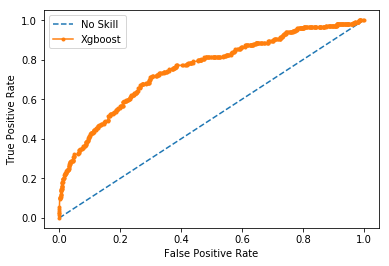

In [11]:
# predict probabilities
xgb_prob = clf_xgb.predict_proba(X_test)

# keep probabilities for the positive outcome only
xgb_prob = xgb_prob[:,1]

# calculate AUC and ROC curve
xgb_auc_roc, xgb_fpr, xgb_tpr, _xgb_th = metrics.plot_roc_curve(y_test,xgb_prob
                                                                ,'Xgboost')

**Precision-recall curve**  
Although there is a bit of overfitting. The precision-recall curve is not good (f1 score relatively low)

Xgboost: f1=0.220 auc=0.280


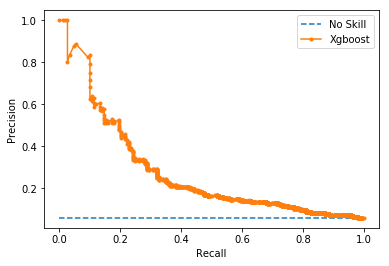

In [12]:
# precision, recall and f1
xgb_f1, xgb_precision, xgb_recall = metrics.plot_prec_rec(y_test,pred_xgb,xgb_prob,
                                                                   'Xgboost')

**Roc and precision and recall curves** to check possible overfitting   
The AUC is lower in training than in test!! It maybe because of the random choice of sets and because although I tune d the algorithm with Gridsearch and cv, the fitted classifier, doesn't include CV.  
I have applied CV in the final results metrics but not for the construction of the Roc and precision en recall curves.  
From precision and recall curve I can deduce that I have some overfitting.

No Skill: ROC AUC=0.500
XGB train: ROC AUC=0.661


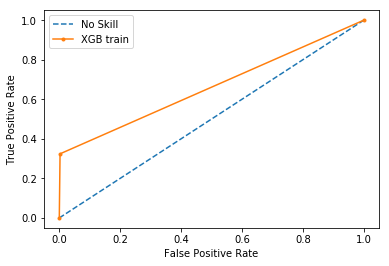

In [13]:
# AUC and Roc curve for training set
pred_train_xgb = clf_xgb.predict(X_train)
predic_prob_train_xgb =  clf_xgb.predict_proba(X_train)[:,1]
a, b, c, d = metrics.plot_roc_curve(y_train,pred_train_xgb, 'XGB train')

XGB train: f1=0.475 auc=0.808


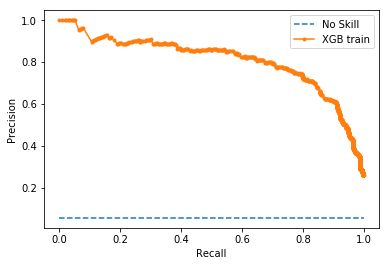

In [14]:
# Precision and recall curve for training set
x,y,z =metrics.plot_prec_rec(y_train,pred_train_xgb,predic_prob_train_xgb, 
                              'XGB train')

**4) Results summary on test dataset**  

In [15]:
X = dataset_for_modeling.X
y = dataset_for_modeling.y
result = pd.DataFrame(index=['recall', 'auc_roc','f1'])
result['clf_xgb'] = [cross_val_score(clf_xgb,X,y,scoring='recall',cv=5).mean(),
                     cross_val_score(clf_xgb,X,y,scoring='roc_auc',cv=5).mean(),
                     cross_val_score(clf_xgb,X,y,scoring='f1',cv=5).mean()]

In [16]:
result

,clf_xgb
recall,0.120833
auc_roc,0.745001
f1,0.173855


**Additional analysis: Find Optimal cut-off**   
To improve the recall I am going to try to look for an optimum threshold. To calculate the optimal cut-off (true positive rate - false positive rate == 0).  
I use the function **metrics.Find_Optimal_Cutoff**.   
The optimal cut-off is very low: 0.065

In [17]:
# Add prediction probability to dataframe
data = pd.DataFrame()
data['pred_proba'] = pd.Series(xgb_prob)

# Find optimal probability threshold
threshold = metrics.Find_Optimal_Cutoff(y_test,data['pred_proba'])

# Find prediction to the dataframe applying threshold
data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix
metrics.plot_cm(y_test,data['pred'])

The optimal cut-off is: 0.07
Confusion matrix:
[[1678  708]
 [  45  104]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.82      2386
           1       0.13      0.70      0.22       149

    accuracy                           0.70      2535
   macro avg       0.55      0.70      0.52      2535
weighted avg       0.92      0.70      0.78      2535



Xgboost optimal cutoff: f1=0.216 auc=0.280


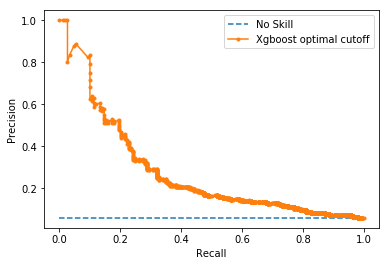

In [18]:
xgb_opt_f1, xgb_opt_precision, xgb_opt_recall = metrics.plot_prec_rec(y_test,data['pred'],
                                                                      xgb_prob,
                                                                      'Xgboost optimal cutoff')

In [19]:
result['xgb_opt_cutoff'] = [recall_score(y_test,data['pred']),
                            cross_val_score(clf_xgb,X,y,scoring='roc_auc',cv=5).mean(),
                            xgb_opt_f1]

In [20]:
result['clf_xgb_no cv'] = [recall_score(y_test,pred_xgb),
                            cross_val_score(clf_xgb,X,y,scoring='roc_auc',cv=5).mean(),
                            xgb_f1]

Compare results (they are not fully comparable because the recall and f1 have not been evaluated with cross validation in the second sceario).   
For the sake of comparison, I generate a new alternative (classifier with threshold by default = 0.5) and metrics evaluation without crossvalidation (clf_xgb_no cv).  
No surprises. When I decrease the threshold (xgb_opt_cutoff), the recall improves at precision expense (f1 score is a bit lower)

In [21]:
result

,clf_xgb,xgb_opt_cutoff,clf_xgb_no cv
recall,0.120833,0.697987,0.134228
auc_roc,0.745001,0.745001,0.745001
f1,0.173855,0.216441,0.219780


Most of class 1 probabilities are around 0.1 (it explains the low optimal cut off). 

Class 1 probability distribution:


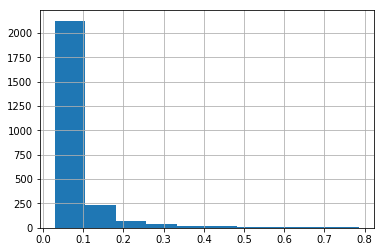

In [22]:
print('Class 1 probability distribution:')
data['pred_proba'].hist();

Class 0 probability distribution:


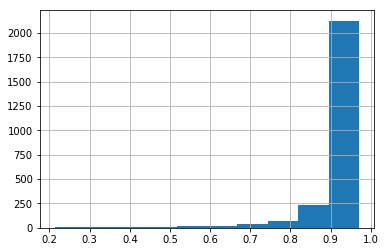

In [23]:
xgb_prob2 = clf_xgb.predict_proba(X_test)
data['pred_proba0'] = pd.Series(xgb_prob2[:,0])
print('Class 0 probability distribution:')
data['pred_proba0'].hist();